Dataset Created Successfully
   age   income  loan_amount  loan_term_month  credit_score  employment_years  \
0   59  30000.0       7796.0               36         709.0                 2   
1   49  30000.0       7377.0               60         607.0                10   
2   35  30000.0      30502.0               36         549.0                 0   
3   63   9333.0      15697.0               36         577.0                 3   
4   28  30000.0      15762.0               48         662.0                 6   

   prior_defaults marital_status             purpose  default  
0               0       divorced  debt_concolidation        1  
1               0        married  debt_concolidation        0  
2               0       divorced  debt_concolidation        1  
3               0        married  debt_concolidation        1  
4               0        married  debt_concolidation        0  

== Logistic Regression ===
ROC AUC: 0.9143
              precision    recall  f1-score   support

 

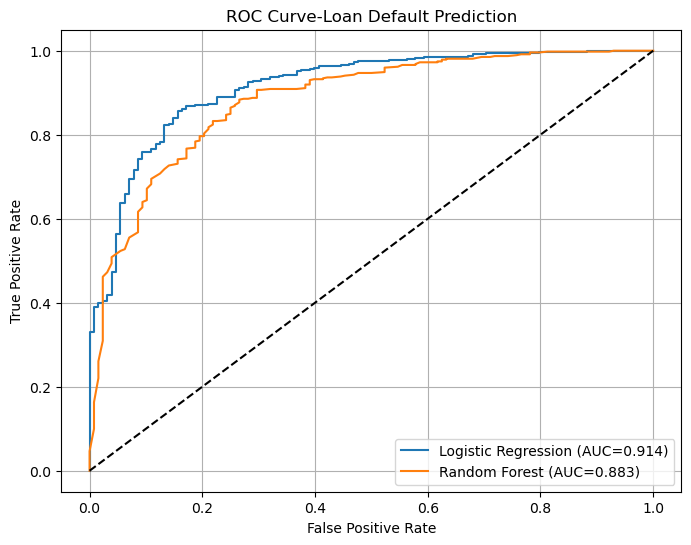

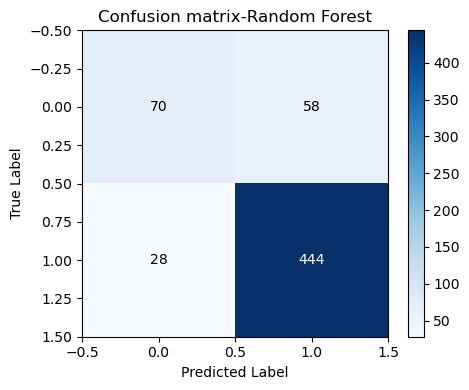

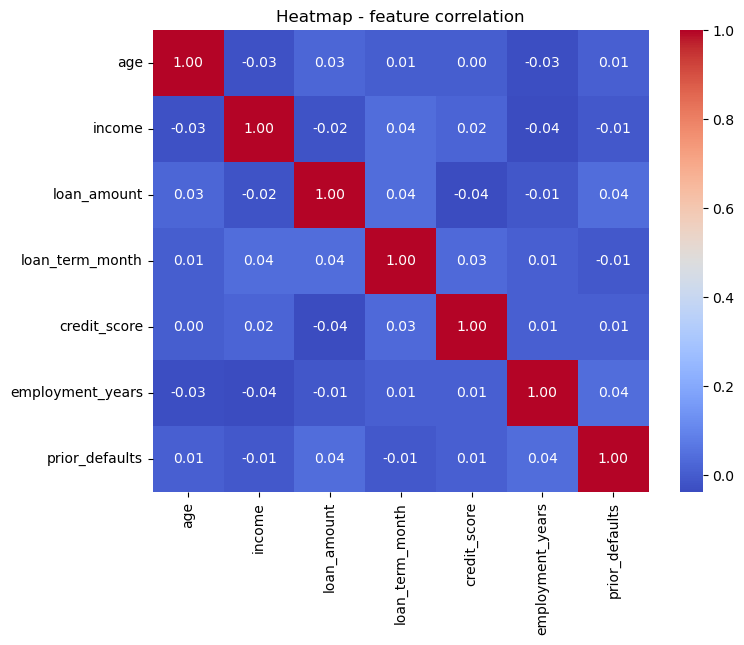

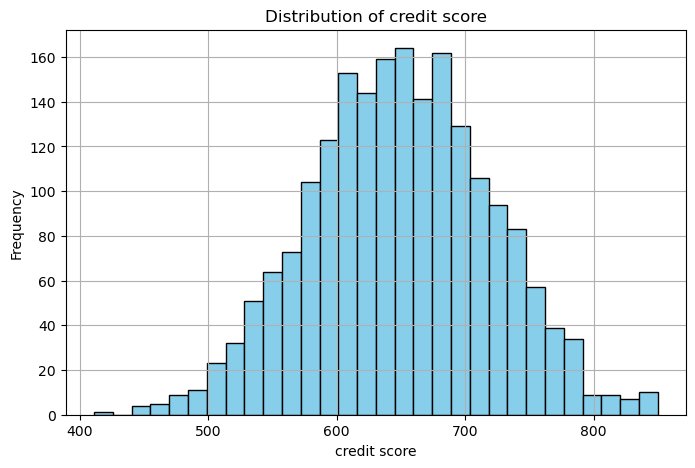

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#Dummy Dataset
np.random.seed(42)
n = 2000

age = np.random.randint(21,70,size=n)
income = np.round(np.random.normal(60000,25000,size = n)).clip(8000,30000)
loan_amount = np.round(np.random.normal(15000,10000,size =n)).clip(1000,100000)                  
loan_term_month = np.random.choice([12,24,36,48,60],size = n,p=[0.05,0.15,0.4,0.25,0.15])
credit_score = np.round(np.random.normal(650,70, size = n)).clip(300,850)
employment_years = np.round(np.random.exponential(scale = 3,size = n)).astype(int)
prior_defaults = np.random.choice([0,1],size = n,p=[0.9,0.1])
marital_status = np.random.choice(['single','married','divorced','widowed'],size=n,p=[0.45,0.45,0.07,0.03])
purpose = np.random.choice(['debt_concolidation','home_improvement','education','car','other'],
                           size=n, p=[0.5,0.15,0.1,0.15,0.1])

#probability of defaults formula
loan_income_ratio = loan_amount / (income + 1)
score = (
    -3.0 *(credit_score - 650) / 100.0
    +6.0 * loan_income_ratio
    -0.2 * employment_years
    +2.5 * prior_defaults
    +np.where(purpose == 'debt_consolidation',0.5,0.0)
    +np.where(marital_status == 'single',0.1,0.0)
)
prob_default = 1/(1 + np.exp(-score))
default = (np.random.rand(n) < prob_default).astype(int)

df = pd.DataFrame ({
    'age': age,
    'income':income,
    'loan_amount':loan_amount,
    'loan_term_month':loan_term_month,
    'credit_score':credit_score,
    'employment_years':employment_years,
    'prior_defaults':prior_defaults,
    'marital_status':marital_status,
    'purpose':purpose,
    'default':default
})

print("Dataset Created Successfully")
print(df.head())

#data preprocessing
X = df.drop(columns = ['default'])
y = df['default']

#categorial columns
X = pd.get_dummies(X,columns = ['marital_status','purpose'], drop_first = True)

#split dataset
X_train,X_test,y_train,y_test = train_test_split(
    X,y, test_size = 0.30,stratify = y , random_state = 42
)

#Scale numeric columns
nums_cols = ['age','income','loan_amount','loan_term_month','credit_score','employment_years','prior_defaults']
scaler = StandardScaler()
X_train[nums_cols] = scaler.fit_transform(X_train[nums_cols])
X_test[nums_cols] = scaler.transform(X_test[nums_cols])

#Train mopdel
lr = LogisticRegression (max_iter = 1000,solver = 'liblinear')
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)

lr.fit (X_train,y_train)
rf.fit(X_train,y_train)

#EValuate model
models = {'Logistic Regression':lr,'Random Forest':rf}
results = {}

for name,model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test,y_prob)
    report = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    results[name] = {'auc':auc,'report':report,'cm':cm}
    print(f"\n== {name} ===")
    print(f"ROC AUC: {auc:0.4f}")
    print(report)
    print("Confusion Matrix:\n",cm)

#plot ROC CURVE
plt.figure(figsize = (8,6))
for name,model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,y_prob)
    auc = roc_auc_score(y_test,y_prob)
    plt.plot(fpr,tpr,label = f"{name} (AUC={auc:0.3f})")

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Loan Default Prediction')
plt.legend()
plt.grid(True)
plt.show()

#Confusion matrix(random forest)
cm = results['Random Forest']['cm']
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation = 'nearest',cmap=plt.cm.Blues)
plt.title('Confusion matrix-Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,format(cm[i,j],'d'),
                 ha = "center",va="center",
                 color = "white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
corr = df.select_dtypes(include=[np.number]).drop(columns=["default"]).corr()
sns.heatmap(corr, annot = True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap - feature correlation")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(df['credit_score'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of credit score")
plt.xlabel("credit score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

